# School District Spending and Achievement Analysis

By Alexis Kedo

Insert data source

## Introduction and Business Understanding

It is generally accepted that high levels of education funding tend to have a positive impact on students' academic achievement, as more money generally allows a district to higher better-qualified, more experienced teachers, purchase high-quality materials, and provide more services to meet students' myriad social, emotional, and learning needs. 

However, the relative impacts of district, state, and federal money are murkier. Though virtually all school districts receive varying levels of each, the extent to which each funding category impacts student achievement is unclear. Furthermore, the impact of federal and state funding on specific localities is rarely explored, as local achievement data is not as readily available as national and state-level assessment results. 

For my analysis, I combined several available public education datasets in an attempt to create an accurate predictor of reading scores for all students in a particular school district, based on that district's proportion of state, local, and federal funding, as well as raw amounts for funding at each level. I aim to help the U.S. Department of Education identify ideal proportions of funding at each level, as well as determine if federal funding, specficially, has a discernible impact on a district's reading achievement. 

Business Question: How do different levels of government revenue and spending on public education (e.g., the ratio of federal spending to total spending) impact whether or not a district's achievement level is over 50%? 

In [1]:
# Import all necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import functions as fn

In [2]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, plot_confusion_matrix, precision_score, recall_score 

#from category_encoders import CountEncoder

## Data Preparation & Cleaning

I have two school expenditure data frames to work from - one that I will use to match states with district names, 
and one with the 2018 expenditure info from which I'll pull all predictor variables. 


In [3]:
df = pd.read_excel('district_data/elsec18t.xls')

In [4]:
df.head()

,IDCENSUS,NAME,CONUM,CSA,CBSA,NCESID,ENROLL,TOTALREV,TFEDREV,FEDRCOMP,...,PPSALWG,PPEMPBEN,PPITOTAL,PPISALWG,PPIEMBEN,PPSTOTAL,PPSPUPIL,PPSSTAFF,PPSGENAD,PPSSCHAD
0,1500100100000,AUTAUGA COUNTY SCHOOL DISTRICT,1001,N,33860,0100240,9247,82258,7240,1805,...,4750,2005,4927,3244,1277,2704,435,218,176,513
1,1500200100000,BALDWIN COUNTY SCHOOL DISTRICT,1003,380,19300,0100270,31782,372175,25803,6930,...,5305,2104,5411,3488,1338,3390,613,360,125,620
2,1500300100000,BARBOUR COUNTY SCHOOL DISTRICT,1005,N,21640,0100300,824,10016,2269,1103,...,6335,2559,6011,3608,1432,5115,562,441,966,738
3,1500300200000,EUFAULA CITY SCHOOL DISTRICT,1005,N,21640,0101410,4619,35701,3849,1146,...,3217,1310,3459,2086,833,2020,371,161,246,429
4,1500400100000,BIBB COUNTY SCHOOL DISTRICT,1007,142,13820,0100360,3252,33360,3811,1049,...,5406,2217,5089,3284,1279,3682,645,493,352,639


In [5]:
df.shape

(14274, 66)

In [6]:
#Drop all unnecessary columns, keeping only district info and predictors
districts = df[['IDCENSUS', 'NCESID','NAME','ENROLL','TOTALREV','TFEDREV','FEDRCOMP','TSTREV','TLOCREV','LOCRPROP','TCURSPND','TCURINST','PCTTOTAL','PCTFTOT','PCTSTOT','PCTLTOT','PCTLTAXP','PPCSTOT','PPSALWG','PPITOTAL','PPISALWG', 'PPSPUPIL']]
districts.head()

,IDCENSUS,NCESID,NAME,ENROLL,TOTALREV,TFEDREV,FEDRCOMP,TSTREV,TLOCREV,LOCRPROP,...,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,PCTLTAXP,PPCSTOT,PPSALWG,PPITOTAL,PPISALWG,PPSPUPIL
0,1500100100000,0100240,AUTAUGA COUNTY SCHOOL DISTRICT,9247,82258,7240,1805,55611,19407,7125,...,100,8.8,67.6,23.6,8.7,8202,4750,4927,3244,435
1,1500200100000,0100270,BALDWIN COUNTY SCHOOL DISTRICT,31782,372175,25803,6930,159101,187271,53499,...,100,6.9,42.7,50.3,14.4,9284,5305,5411,3488,613
2,1500300100000,0100300,BARBOUR COUNTY SCHOOL DISTRICT,824,10016,2269,1103,5425,2322,1338,...,100,22.7,54.2,23.2,13.7,12076,6335,6011,3608,562
3,1500300200000,0101410,EUFAULA CITY SCHOOL DISTRICT,4619,35701,3849,1146,24304,7548,3110,...,100,10.8,68.1,21.1,8.7,5888,3217,3459,2086,371
4,1500400100000,0100360,BIBB COUNTY SCHOOL DISTRICT,3252,33360,3811,1049,22704,6845,1478,...,100,11.4,68.1,20.5,4.4,9491,5406,5089,3284,645


In [7]:
districts.shape

(14274, 22)

In [8]:
#IDs for some states have leading zeroes, which makes them incompatible when we try to merge with achievement data.
# We need to create a function to drop the leading zero from the NCESID in the "districts" dataframe. 
test = []
for i, element in enumerate(districts['NCESID']): 
    if element.startswith("0"): 
        test.append((element[1:])) #Drop first character if the string starts with 0
    else: 
        test.append(element)

In [9]:
set1 = set(test)

In [10]:
len(test)

14274

In [11]:
len(districts)

14274

In [12]:
districts['NCESID'] = test
districts.head()

<ipython-input-12-572f58041426>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  districts['NCESID'] = test


,IDCENSUS,NCESID,NAME,ENROLL,TOTALREV,TFEDREV,FEDRCOMP,TSTREV,TLOCREV,LOCRPROP,...,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,PCTLTAXP,PPCSTOT,PPSALWG,PPITOTAL,PPISALWG,PPSPUPIL
0,1500100100000,100240,AUTAUGA COUNTY SCHOOL DISTRICT,9247,82258,7240,1805,55611,19407,7125,...,100,8.8,67.6,23.6,8.7,8202,4750,4927,3244,435
1,1500200100000,100270,BALDWIN COUNTY SCHOOL DISTRICT,31782,372175,25803,6930,159101,187271,53499,...,100,6.9,42.7,50.3,14.4,9284,5305,5411,3488,613
2,1500300100000,100300,BARBOUR COUNTY SCHOOL DISTRICT,824,10016,2269,1103,5425,2322,1338,...,100,22.7,54.2,23.2,13.7,12076,6335,6011,3608,562
3,1500300200000,101410,EUFAULA CITY SCHOOL DISTRICT,4619,35701,3849,1146,24304,7548,3110,...,100,10.8,68.1,21.1,8.7,5888,3217,3459,2086,371
4,1500400100000,100360,BIBB COUNTY SCHOOL DISTRICT,3252,33360,3811,1049,22704,6845,1478,...,100,11.4,68.1,20.5,4.4,9491,5406,5089,3284,645


In [13]:
# Now, import reading assessment  data
reading = pd.read_csv('lea_reading.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (18,20,22,26,36,38,40,42,44,46,50,52,54,98,108,112,114,122,124,126,128,130,136,138,140,144,150,152,154,156,158,162,170,180,182,184,192,194,236,240,248,250,254,256,258,260) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
reading.head()

,STNAM,FIPST,LEANM,LEAID,ST_LEAID,DATE_CUR,ALL_RLA00numvalid_1819,ALL_RLA00pctprof_1819,MAM_RLA00numvalid_1819,MAM_RLA00pctprof_1819,...,MIL_RLA05numvalid_1819,MIL_RLA05pctprof_1819,MIL_RLA06numvalid_1819,MIL_RLA06pctprof_1819,MIL_RLA07numvalid_1819,MIL_RLA07pctprof_1819,MIL_RLA08numvalid_1819,MIL_RLA08pctprof_1819,MIL_RLAHSnumvalid_1819,MIL_RLAHSpctprof_1819
0,ALABAMA,1,Albertville City,100005,AL-101,13AUG20,2869,38,8,GE50,...,9,GE50,11,GE50,6,GE50,14,GE50,7,LT50
1,ALABAMA,1,Marshall County,100006,AL-048,13AUG20,2938,36,13,LT50,...,NaN,NaN,1,PS,NaN,NaN,2,PS,1,PS
2,ALABAMA,1,Hoover City,100007,AL-158,13AUG20,7442,65,5,PS,...,20,60-79,15,GE50,9,GE50,11,GE50,9,GE50
3,ALABAMA,1,Madison City,100008,AL-169,13AUG20,5867,73,39,70-79,...,26,GE80,30,GE80,33,60-69,37,60-69,30,60-79
4,ALABAMA,1,Leeds City,100011,AL-167,13AUG20,1064,42,1,PS,...,1,PS,7,LT50,NaN,NaN,2,PS,3,PS


This dataframe contains a ton of columns that divide students into subgroups. For our purposes we're interested in reading achievement data for all kids who tested in that district during the 2018-2019 school year. 
- The "ALL_RLA00numvalid_1819" column gives the total number of kids in 3rd-12th grade who completed a reading assessment and for whom a proficiency level was assigned. 
- The "ALL_RLA00pctprof_1819" column gives the percentage of students who scored at or above proficient in reading.

Because I taught 4th grade ELA and am partial to it (it's an important year for reading!), I'm also interested in 4th grade specific reading data. 
- The "ALL_RLA04numvalid_1819" gives the total number of 4th graders who sat for a reading assessment and for whom a proficiency level was assigned. 
- The "ALL_RLA04pctprof_1819" gives the percentage of 4th grade students who scored at or above proficient in reading. 

In [15]:
# Create new dataframe that selects the target columns mentioned above, along with any important location data 
achievement = reading[['STNAM','LEANM', 'LEAID','ALL_RLA00numvalid_1819','ALL_RLA00pctprof_1819','ALL_RLA04numvalid_1819','ALL_RLA04pctprof_1819']]
achievement.head()

,STNAM,LEANM,LEAID,ALL_RLA00numvalid_1819,ALL_RLA00pctprof_1819,ALL_RLA04numvalid_1819,ALL_RLA04pctprof_1819
0,ALABAMA,Albertville City,100005,2869,38,442,41
1,ALABAMA,Marshall County,100006,2938,36,417,33
2,ALABAMA,Hoover City,100007,7442,65,1049,64
3,ALABAMA,Madison City,100008,5867,73,768,78
4,ALABAMA,Leeds City,100011,1064,42,148,35-39


In [16]:
achievement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17396 entries, 0 to 17395
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   STNAM                   17396 non-null  object
 1   LEANM                   17396 non-null  object
 2   LEAID                   17396 non-null  int64 
 3   ALL_RLA00numvalid_1819  17396 non-null  int64 
 4   ALL_RLA00pctprof_1819   17396 non-null  object
 5   ALL_RLA04numvalid_1819  15337 non-null  object
 6   ALL_RLA04pctprof_1819   15298 non-null  object
dtypes: int64(2), object(5)
memory usage: 951.5+ KB


After some reading I found that the LEA ID in the achievement data is the same as the NCES ID in the expenditure data. We should be safe to merge our financials with our achievement data using this ID. However, we can't merge a string and an integer column together so first we need to convert the "LEAID" to string format.

In [17]:
achievement['LEAID'] = achievement['LEAID'].astype(str)

<ipython-input-17-11fa45cbc62e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  achievement['LEAID'] = achievement['LEAID'].astype(str)


In [18]:
final = pd.merge(districts, achievement, left_on='NCESID', right_on='LEAID')
final.head()

,IDCENSUS,NCESID,NAME,ENROLL,TOTALREV,TFEDREV,FEDRCOMP,TSTREV,TLOCREV,LOCRPROP,...,PPITOTAL,PPISALWG,PPSPUPIL,STNAM,LEANM,LEAID,ALL_RLA00numvalid_1819,ALL_RLA00pctprof_1819,ALL_RLA04numvalid_1819,ALL_RLA04pctprof_1819
0,1500100100000,100240,AUTAUGA COUNTY SCHOOL DISTRICT,9247,82258,7240,1805,55611,19407,7125,...,4927,3244,435,ALABAMA,Autauga County,100240,4915,55,765,58
1,1500200100000,100270,BALDWIN COUNTY SCHOOL DISTRICT,31782,372175,25803,6930,159101,187271,53499,...,5411,3488,613,ALABAMA,Baldwin County,100270,17226,56,2462,57
2,1500300100000,100300,BARBOUR COUNTY SCHOOL DISTRICT,824,10016,2269,1103,5425,2322,1338,...,6011,3608,562,ALABAMA,Barbour County,100300,377,16,61,30-34
3,1500300200000,101410,EUFAULA CITY SCHOOL DISTRICT,4619,35701,3849,1146,24304,7548,3110,...,3459,2086,371,ALABAMA,Eufaula City,101410,3107,34,392,34
4,1500400100000,100360,BIBB COUNTY SCHOOL DISTRICT,3252,33360,3811,1049,22704,6845,1478,...,5089,3284,645,ALABAMA,Bibb County,100360,1657,37,219,35-39


In [19]:
# Drop redundant columns
final = final.drop(['LEANM','LEAID'], axis=1)

In [20]:
# Move some columns around
list(final.columns)

['IDCENSUS',
 'NCESID',
 'NAME',
 'ENROLL',
 'TOTALREV',
 'TFEDREV',
 'FEDRCOMP',
 'TSTREV',
 'TLOCREV',
 'LOCRPROP',
 'TCURSPND',
 'TCURINST',
 'PCTTOTAL',
 'PCTFTOT',
 'PCTSTOT',
 'PCTLTOT',
 'PCTLTAXP',
 'PPCSTOT',
 'PPSALWG',
 'PPITOTAL',
 'PPISALWG',
 'PPSPUPIL',
 'STNAM',
 'ALL_RLA00numvalid_1819',
 'ALL_RLA00pctprof_1819',
 'ALL_RLA04numvalid_1819',
 'ALL_RLA04pctprof_1819']

In [21]:
final = final[['IDCENSUS',
 'NCESID',
 'STNAM',
 'NAME',
 'ENROLL',
 'ALL_RLA00numvalid_1819',
 'ALL_RLA00pctprof_1819',
 'ALL_RLA04numvalid_1819',
 'ALL_RLA04pctprof_1819',              
 'TOTALREV',
 'TFEDREV',
 'FEDRCOMP',
 'TSTREV',
 'TLOCREV',
 'LOCRPROP',
 'TCURSPND',
 'TCURINST',
 'PCTTOTAL',
 'PCTFTOT',
 'PCTSTOT',
 'PCTLTOT',
 'PCTLTAXP',
 'PPCSTOT',
 'PPSALWG',
 'PPITOTAL',
 'PPISALWG',
 'PPSPUPIL'
 ]]

In [22]:
final.head()

,IDCENSUS,NCESID,STNAM,NAME,ENROLL,ALL_RLA00numvalid_1819,ALL_RLA00pctprof_1819,ALL_RLA04numvalid_1819,ALL_RLA04pctprof_1819,TOTALREV,...,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,PCTLTAXP,PPCSTOT,PPSALWG,PPITOTAL,PPISALWG,PPSPUPIL
0,1500100100000,100240,ALABAMA,AUTAUGA COUNTY SCHOOL DISTRICT,9247,4915,55,765,58,82258,...,100,8.8,67.6,23.6,8.7,8202,4750,4927,3244,435
1,1500200100000,100270,ALABAMA,BALDWIN COUNTY SCHOOL DISTRICT,31782,17226,56,2462,57,372175,...,100,6.9,42.7,50.3,14.4,9284,5305,5411,3488,613
2,1500300100000,100300,ALABAMA,BARBOUR COUNTY SCHOOL DISTRICT,824,377,16,61,30-34,10016,...,100,22.7,54.2,23.2,13.7,12076,6335,6011,3608,562
3,1500300200000,101410,ALABAMA,EUFAULA CITY SCHOOL DISTRICT,4619,3107,34,392,34,35701,...,100,10.8,68.1,21.1,8.7,5888,3217,3459,2086,371
4,1500400100000,100360,ALABAMA,BIBB COUNTY SCHOOL DISTRICT,3252,1657,37,219,35-39,33360,...,100,11.4,68.1,20.5,4.4,9491,5406,5089,3284,645


Now that we have our dataframe set up, we need to figure out how to handle our target variables. Right now, they are reported as percentages of students who sat for completed and scored at least a "Proficient" on a reading assessment during the 2018-2019 school year.

In [23]:
final['ALL_RLA00pctprof_1819'].min()

'10'

In [24]:
final['ALL_RLA00pctprof_1819'].max()

'PS'

In [25]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13333 entries, 0 to 13332
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   IDCENSUS                13333 non-null  int64  
 1   NCESID                  13333 non-null  object 
 2   STNAM                   13333 non-null  object 
 3   NAME                    13333 non-null  object 
 4   ENROLL                  13333 non-null  int64  
 5   ALL_RLA00numvalid_1819  13333 non-null  int64  
 6   ALL_RLA00pctprof_1819   13333 non-null  object 
 7   ALL_RLA04numvalid_1819  12730 non-null  object 
 8   ALL_RLA04pctprof_1819   12696 non-null  object 
 9   TOTALREV                13333 non-null  int64  
 10  TFEDREV                 13333 non-null  int64  
 11  FEDRCOMP                13333 non-null  int64  
 12  TSTREV                  13333 non-null  int64  
 13  TLOCREV                 13333 non-null  int64  
 14  LOCRPROP                13333 non-null

In [26]:
pd.set_option('display.max_rows', 10)
final['ALL_RLA00pctprof_1819'].value_counts(ascending=False)

50-54    288
45-49    267
47       256
35-39    253
49       245
        ... 
GE90       2
LE1        2
GE95       1
96         1
4          1
Name: ALL_RLA00pctprof_1819, Length: 134, dtype: int64

In [27]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13333 entries, 0 to 13332
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   IDCENSUS                13333 non-null  int64  
 1   NCESID                  13333 non-null  object 
 2   STNAM                   13333 non-null  object 
 3   NAME                    13333 non-null  object 
 4   ENROLL                  13333 non-null  int64  
 5   ALL_RLA00numvalid_1819  13333 non-null  int64  
 6   ALL_RLA00pctprof_1819   13333 non-null  object 
 7   ALL_RLA04numvalid_1819  12730 non-null  object 
 8   ALL_RLA04pctprof_1819   12696 non-null  object 
 9   TOTALREV                13333 non-null  int64  
 10  TFEDREV                 13333 non-null  int64  
 11  FEDRCOMP                13333 non-null  int64  
 12  TSTREV                  13333 non-null  int64  
 13  TLOCREV                 13333 non-null  int64  
 14  LOCRPROP                13333 non-null

According to the documentation for the achievement data, the code "PS" is used to supporess data in order to protect student privacy, and no actual achievement level is reported. Since this won't be useful for our analysis, we want to drop all rows with "PS" in the achievement column.

In [28]:
final.value_counts(final['ALL_RLA00pctprof_1819'] == 'PS')

ALL_RLA00pctprof_1819
False    13192
True       141
dtype: int64

In [29]:
final = final.loc[final['ALL_RLA00pctprof_1819'] != 'PS']

In [30]:
final.shape

(13192, 27)

In [31]:
final['ALL_RLA00pctprof_1819'].unique()

array(['55', '56', '16', '34', '37', '46', '54', '17', '28', '27', '49',
       '59', '51', '50', '38', '23', '41', '39', '25', '48', '47', '35',
       '61', '30', '45', '66', '53', '36', '29', '43', '42', '57', '22',
       '24', '19', '71', '65', '83', '68', '79', '44', '64', '21', '73',
       '40', '33', '32', '52', '20-24', '10-14', 'LT50', 'LE1', '6',
       '50-54', '7', '35-39', '3', 'LE5', '31', '25-29', '20-29', '65-69',
       '10', '12', '69', '30-34', '40-49', '85-89', '40-44', '11-19',
       '50-59', '21-39', 'LE10', 'GE50', '60-64', 'LE20', '70-79', '15',
       '45-49', '40-59', '13', '30-39', '55-59', '26', '5', '67', '60',
       '58', '63', '60-79', '6-9', '70', '62', '20', '14', '18', '15-19',
       '9', '8', '87', '80-84', '78', '89', '84', '86', '81', '74', '72',
       '60-69', 'GE80', '77', '75', '85', '76', '88', '90', '82', '90-94',
       '70-74', '75-79', '80-89', '80', '11', '91', 'GE90', '4', '95',
       'GE95', '98', '96', '93', '94', '92'], dtype=obj

Now that the supressed data is removed from our dataframe, we can proceed with transforming our target column. Many of the proficiency results are ranges (e.g., 70-74). Because the consequences of falsely labeling a child as "Proficient" when they are, in fact, not, are largely thought of as more serious than falsely labeling a student as "Not Proficient" when they, in fact, are proficient, I have decided to take the lower end of these ranges as the assumed level of proficiency for that district. 

We'll create a function that iterates through our target column and extracts the appropriate number from that value to represent the achivement level. 

In [32]:
test = []
for i, element in enumerate(final['ALL_RLA00pctprof_1819']): 
    if ("E" in element) or  ("T" in element): 
        test.append((element[2:])) #Drop first two characters if there is an "E" in the value
    elif "6-9" == element: 
        test.append((element[:1]))
    elif "-" in element: 
        test.append((element[:2]))   
    else: 
        test.append(element)

In [33]:
set1 = set(test)

In [34]:
len(test)

13192

In [35]:
len(final)

13192

In [36]:
final['target'] = test

In [37]:
final[['ALL_RLA00pctprof_1819','target']]

,ALL_RLA00pctprof_1819,target
0,55,55
1,56,56
2,16,16
3,34,34
4,37,37
...,...,...
13328,55,55
13329,55-59,55
13330,71,71
13331,62,62


In [38]:
final = final.drop('ALL_RLA00pctprof_1819', axis=1)

In [39]:
# Now writing a function to convert target column to boolean values. 
test2 = final.copy().reset_index()

test2['target_conv'] = 0

#final['target'] = final['target'].astype(int)
for i, number in enumerate(test2['target']):
    if int(number) >= 50: 
        test2.at[i,'target_conv'] = 1 
    else: 
        test2.at[i,'target_conv'] = 0

In [40]:
set2 = set(test2['target_conv'])

In [41]:
set2

{0, 1}

In [42]:
final = test2

In [43]:
final = final.rename(columns = {'ALL_RLA00numvalid_1819':'total_students', 'ALL_RLA04numvalid_1819':'total_4th','ALL_RLA04pctprof_1819':'_4th_proficient', 'target':'perc_prof'})

In [44]:
#Transforming 4th grade columns I didn't end up using, as well as an NCESID column I no longer need
final = final.drop(['total_4th','_4th_proficient','NCESID'], axis=1)

In [45]:
#Transforming some other columns to more accurately reflect the type of data contained in them 
final['IDCENSUS'] = final[['IDCENSUS']].astype(object)
final['perc_prof'] = final[['perc_prof']].astype(int) 

In [46]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13192 entries, 0 to 13191
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           13192 non-null  int64  
 1   IDCENSUS        13192 non-null  object 
 2   STNAM           13192 non-null  object 
 3   NAME            13192 non-null  object 
 4   ENROLL          13192 non-null  int64  
 5   total_students  13192 non-null  int64  
 6   TOTALREV        13192 non-null  int64  
 7   TFEDREV         13192 non-null  int64  
 8   FEDRCOMP        13192 non-null  int64  
 9   TSTREV          13192 non-null  int64  
 10  TLOCREV         13192 non-null  int64  
 11  LOCRPROP        13192 non-null  int64  
 12  TCURSPND        13192 non-null  int64  
 13  TCURINST        13192 non-null  int64  
 14  PCTTOTAL        13192 non-null  int64  
 15  PCTFTOT         13192 non-null  float64
 16  PCTSTOT         13192 non-null  float64
 17  PCTLTOT         13192 non-null 

## Data Understanding and Exploration 

### Target
As stated above, my target variable is reading achievement for a particular district, expressed in the "target" column above as the % of students rated as "Proficient" or above in  Language Arts). Above, I transformed this target into a binary and coded it as the following: 
- 0: District/LEA has 49% or fewer all students testing "Proficient" or above in reading
- 1: District/Lea has 50% of more all students testing "Proficient" or above in reading

I also thought it would be interesting to look at reading proficiency for a particular grade; my combined dataset initially included data for 4th grade (as shown above in Columns 7 and 8 above ("total_4th" and "4th_proficient")). To start off, we will look at district achivement holistically for all grade levels; however, there is an opportunity to drill down to this specific age group. 

### Predictors
I currently have 17 different predictors, each representing a different characteristic of a particular school district's revenue from federal, state, and local sources: 
- TOTALREV = Total Revenue (raw number) - combo of Federal, State, and Local Revenue
- TFEDREV = Federal Revenue (raw number)
- FEDRCOMP = Compensatory (Title 1) Revenue
- TSTREV = State Revenue (raw number)
- TLOCREV = Local Revenue (raw number) 
- LOCRPROP = Property Taxes (Raw number)
- PCTTOTAL = Percentage of elementary-secondary revenue over total 
- PCTFTOT = Federal:Overall Revenue (percentage) - how much of an LEA's total revenue is comprised of money from Federal Sources
- PCTSTOT = State:Overall Revenue (percentage) - how much of a district's total revenue is comprised of money from state sources
- PCTLTOT = Local:Overall Revenue (percentage) how much of a district's total revenue is comprised of money from local sources 
- PCTLTAXP = taxes and parent government contributions (percentage)
- TCURSPND = Total current spending for elementary-secondary programs (Includes spending for instruction, student support services, and other (food services, enterprise operations). Does not include capital outlay expenditures (construction, land purchase, instructional equipment, state payments for captial outlay, payments to state, local governments or other school systems, and/or interest on school system debt). 
- TCURINST = Total current spending for instruction (raw number) 
- PPCSTOT = per pupil - total current spending (raw number)
- PPSALWG - per pupuil - total salaries and wages (raw number)
- PPITOTAL = per pupil - current total spending for instruction (raw number)
- PPISALWG - per pupil - salaries and wages for instruction (raw number)

Since these each show a different aspect of a school's funding base, and there are relatively few, I'll keep all predictors in for now. I'm particularly interested in seeing how the last three variables concerning employee salaries and money spent purely on instruction (including teacher salaries) may impact reading achivement. 

In [47]:
# Exploring balance of target classes
final['target_conv'].value_counts(normalize=True)

1    0.500834
0    0.499166
Name: target_conv, dtype: float64

Our target is relatively balanced, with just over 51% of school districts reporting that over half of their students tested proficient in reading.

### Some Exploration

Even though we'll use the boolean column to predict on, I'm interested in the distribution of proficiency levels across the country:

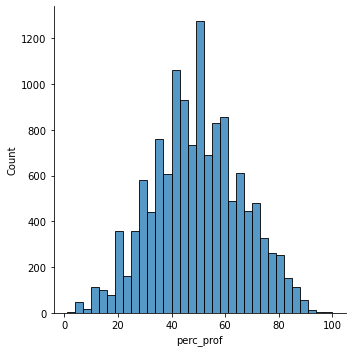

In [48]:
sn.displot(final, x='perc_prof', binwidth=3)

Reading proficiency is normally distributed with a slight right skew, which makes sense given the balance of our binary target. Districts who report 50% proficiency occupy the largest share of our data.

We can do the same to visualize the size of school districts: 

In [49]:
#This is running super slow
#sn.displot(final, x="ENROLL", binwidth=3)

In [50]:
# Exploring numeric columns
num_cols = final[[c for c in final.columns if final[c].dtype == 'int64' or final[c].dtype== 'float64']].describe()
num_cols

,index,ENROLL,total_students,TOTALREV,TFEDREV,FEDRCOMP,TSTREV,TLOCREV,LOCRPROP,TCURSPND,...,PCTSTOT,PCTLTOT,PCTLTAXP,PPCSTOT,PPSALWG,PPITOTAL,PPISALWG,PPSPUPIL,perc_prof,target_conv
count,13192.000000,13192.000000,13192.000000,1.319200e+04,1.319200e+04,13192.000000,1.319200e+04,1.319200e+04,1.319200e+04,1.319200e+04,...,13192.000000,13192.000000,13192.000000,13192.000000,13192.000000,13192.000000,13192.000000,13192.000000,13192.000000,13192.000000
mean,6665.251743,3595.803441,1868.277062,5.205773e+04,3.931425e+03,989.182307,2.422702e+04,2.389928e+04,1.599513e+04,4.460427e+04,...,48.293094,44.200394,35.531602,13769.177683,7614.135461,8085.543966,5076.781610,718.509172,49.186401,0.500834
std,3855.688989,12247.637968,6311.223510,1.736221e+05,1.763369e+04,5582.083172,8.746156e+04,8.313332e+04,6.126130e+04,1.466083e+05,...,18.792807,20.745244,21.276803,9414.050038,4608.393310,5291.135696,2745.006652,1128.997134,16.607772,0.500018
min,0.000000,0.000000,6.000000,1.600000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3318.750000,416.000000,210.750000,6.684000e+03,3.550000e+02,73.000000,2.873750e+03,2.410750e+03,1.027000e+03,5.585750e+03,...,34.900000,28.100000,19.400000,10023.750000,5677.000000,5927.750000,3798.000000,336.000000,38.000000,0.000000
50%,6650.500000,1133.000000,580.000000,1.711550e+04,9.470000e+02,210.000000,8.105500e+03,6.468500e+03,3.544000e+03,1.444600e+04,...,50.550000,41.200000,31.400000,11828.000000,6702.000000,7038.000000,4500.500000,532.000000,50.000000,1.000000
75%,9996.250000,3005.250000,1531.250000,4.526225e+04,2.684000e+03,609.000000,1.986200e+04,1.966600e+04,1.179050e+04,3.871550e+04,...,62.700000,59.000000,49.900000,15614.250000,8501.250000,9238.250000,5742.250000,836.000000,60.000000,1.000000
max,13332.000000,621414.000000,250843.000000,9.974408e+06,1.083978e+06,360581.000000,6.014547e+06,3.301889e+06,2.897871e+06,8.146260e+06,...,100.000000,99.100000,95.900000,418800.000000,172684.000000,314200.000000,158588.000000,75096.000000,98.000000,1.000000


In [51]:
# Exploring object columns
obj_cols = final[[c for c in final.columns if final[c].dtype == 'object']].describe()
obj_cols

,IDCENSUS,STNAM,NAME
count,13192,13192,13192
unique,13192,50,12977
top,14508500100000,TEXAS,LINCOLN CO SCH DIST
freq,1,1032,6


Unsurprisingly, Texas is the most-represented state in the data, with 1,032 school districts. 

### If time, insert reading achievement map here

## Model Prep

### Choosing Evaluation Metrics
In the context of this dataset, the cost of a false positive could be argued as being more significant than that of a false negative. A false positive means here that students in certain districts are labeled as proficient in reading when they, in fact, may not be. This is (arguably) "worse" than labeling a proficient student not-proficient when they, in fact, are. The former, if we play this all the way out, could result in a student falling further and further behind as they progress through school, because their reading difficulties are never diagnosed and thus compound over time. A false negative is still undesirable, yet easier to remedy when it is discovered. 

Though false negatives could result in a mis-allocation of resources to students who are erroneously deemed "not proficient," practitioners are overall much more concerned with students whose true learning needs are not being met, often because they are mis-labeled as "proficient." Therefore, for this analysis, I will focus on minimizing false positives and, thus, maximizing the precision of my model. 

### Feature Engineering

After some thought I decided to drop some columns that seem redundant, as the multicollinearity heatmap was beginning to get crowded and I think some of different columns give us two versions of the same information (e.g., Total Revenue vs. Total Current Spending, assuming a district spends all of its revenue). 

In [52]:
#Splitting data into features and target
target = final['target_conv']
features = final.drop(['index','target_conv','total_students', 'ENROLL','TCURSPND', 'PPSALWG', 'PCTTOTAL', 'PCTFTOT','PCTSTOT','PCTLTOT'], axis = 1)

### Multicollinearity

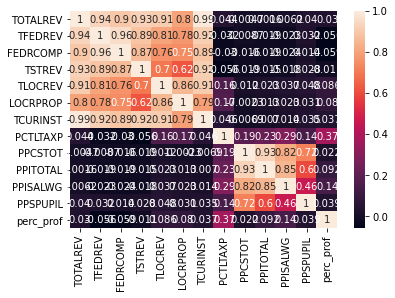

In [53]:
corr = features.corr()
sn.heatmap(corr, annot=True)
plt.show()

As you can see, there was a lot of multicollinearity in my initial heatmap. Predictably, a lot of these raw numbers tend to move together -- for example, local revenue (TLOCREV), state revenue (TSTREV), and federal revenue (TFEDREV) are all highly correlated with each other and with total revenue (TOTALREV), as well as total current spending for instruction (TCURINST). 

For this reason, I decided to eliminate the local revenue column from the data (TLOCREV), as this could be more precisely measured through examining variability in local property taxes (LOCRPROP). I also realized that total current spending on instruction (TCURINST) is more precisely reflected in the per pupil spending for instruction (PPITOTAL). 

Also, there is a high correlation (0.85) between per pupil spending on instructional salaries and wages (PPISALWG) and per pupil spending on instruction (PPITOTAL), which makes sense because the former is included in the latter. To try to minimize some of this correlation, I'll drop the former column.  

The high correlation of 0.93 between PPITOTAL (per pupil spending on instruction) and PPCSTOT (per pupil total current spending) is also concerning. For this model, I will drop the latter feature, as I am more interested as to if spending more money on teacher salaries and wages leads to increased student achievement. Furthermore, it is kind of common sense to think that spending more money on each student will lead to higher student achievement, so I honestly don't think PPCSTOT would be that informative anyway.

Lastly, state revenue (TSTREV) is rather outside the score of my business problem, which concerns federal spending, so I eliminated that as well. I hope these changes will help simplify things (as these features are tough to keep straight) and help my model to avoid confusion. 

In [54]:
features = features.drop(['TLOCREV','TCURINST', 'TFEDREV', 'TSTREV', 'PPCSTOT', 'TOTALREV', 'PPITOTAL'], axis = 1)

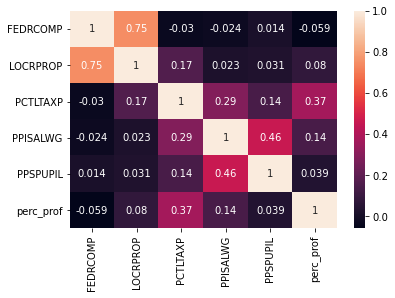

In [55]:
corr = features.corr()
sn.heatmap(corr, annot=True)
plt.show()

After some trial and error, I arrived at a heatmap with five features that are relatively low-correlated to each other. There is still some multicollinearity between local property taxes and Title I funding (at 0.75), which I find strange, because Title I funding is based on the percentage of children living in poverty who attend a certain school. I always thought that Title I funding levels would be inversely related to property taxes...maybe this is not true in urban areas? Anyways, the 0.75 coefficient is not great, but since we are in a much better spot than we were before, I'll proceed for now and see how we do. 

In [56]:
features = features.rename(columns = {"STNAM": "state", "LOCRPROP": "prop_taxes", "FEDRCOMP": "title_1", "PCTLTAXP": "taxes_perc", "PPISALWG": "perstud_salaries", "PPSPUPIL": "perstud_spending"})

In [57]:
features= features.drop(labels={'IDCENSUS','NAME'}, axis = 1)

## Preprocessing Data

### Dealing with Different Data Types

All of the predictors in our pared-down dataset, save one (state name), are numerical. What follows is a final list of what will go into the baseline model. Depending on how the model performs, I may add features back in. 
- 'state': Name of the state in which a school district is located
- 'title_1': Amount of Title I funding a district receives (in thousands of dollars) 
- 'prop_taxes': Amount of property tax revenue a district receives (in thousands of dollars) 
- 'taxes_perc': Percentage of funding that comes from taxes and parent government contributions
- 'perstud_salaries': Amount district spends per pupil on instructional salaries (in dollars)
- 'perstud_spending': Amount distrirct spends per pupil on student support (in dollars)

The numerical columns must be scaled, while the object column ('state') has to get transformed somehow in order to make it meaningful. In preparation for the fit, scaling, and transforming steps that follow, we'll iterate through the columns and assign them to different lists based on their data type. 

#### Train-Test Split

To prevent data leakage during the next few steps when manipulating our categorical data, we'll perform the train-test split now: 

In [58]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

#### Categorical Data

Since there are 50 state possibilities, one-hot encoding would lead to dozens of unnecessary columns. After some thought, I decided to use target encoding to deal with states, using the continuous version of the target to replace each state with the average percentage of students proficient in that state. Though this is an imperfect substitute for location, it is true that states differ markedly from each other in their levels of student achievement and tend to stay consistent from year to year (for example, Massachusetts is continually one of the top-performing states in the nation, while Louisiana is consistently one of the lowest). Thus, treating states this way should feed my model some valuable information about student performance. 

In [59]:
#Target encoding state column 
#Create a groupby dataframe that gives us the mean in each numeric column for each state
state_averages = X_train.groupby(['state']).mean()

In [60]:
state_averages=state_averages['perc_prof'].reset_index()

In [61]:
#Join helper dataframe with my training predictors and testing data
X_train = pd.merge(state_averages, X_train, how = 'inner', on='state').reset_index()
X_test = pd.merge(state_averages, X_test, how = 'inner', on='state').reset_index()

In [62]:
X_train = X_train.drop(['state', 'perc_prof_y'], axis = 1)
X_test = X_test.drop(['state', 'perc_prof_y'], axis = 1)

In [63]:
X_train = X_train.rename(columns = {'perc_prof_x':'avg_state_prof'})
X_test = X_test.rename(columns = {'perc_prof_x':'avg_state_prof'})

In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10553 entries, 0 to 10552
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             10553 non-null  int64  
 1   avg_state_prof    10553 non-null  float64
 2   title_1           10553 non-null  int64  
 3   prop_taxes        10553 non-null  int64  
 4   taxes_perc        10553 non-null  float64
 5   perstud_salaries  10553 non-null  int64  
 6   perstud_spending  10553 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 577.2 KB


In [65]:
X_train.head()

,index,avg_state_prof,title_1,prop_taxes,taxes_perc,perstud_salaries,perstud_spending
0,0,43.127451,1146,3110,8.7,2086,371
1,1,43.127451,2426,21601,11.2,3494,537
2,2,43.127451,690,1732,6.4,3736,660
3,3,43.127451,1729,2733,5.4,3479,726
4,4,43.127451,485,1055,5.9,3561,481


#### Scaling Data
Since all columns are now numeric and continuous, we'll run a standard scaler on all features.

In [66]:
scaler = StandardScaler()
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train, y=None)
X_test_scaled = scaler.transform(X_test)

## Baseline Model(s)

The simplest model would be to predict the majority class which, as stated above, occurs  50% of the time. However, if we predicted all school districts as at or above proficient, that renders half of all school districts nationwide mis-labeled. Hopefully, our future models can do better than that. 

Could our newly created continuous variable (a statewide average proficiency rate) do better than 50%? 

In [67]:
# train = X_train
# train['target'] = y_train

In [68]:
# train.isna().sum()

In [69]:
# test = X_test.reset_index()
# test['target'] = y_test

In [70]:
# Number correct is number of proficient districts with state proficiency > 50%
# and non-proficient districts with state proficiency <50%.

## Model 1: K-Nearest Neighbors

Since we have so few columns, it's worth utilizing a KNN model, as it is typically computationally expensive, but could yield some easily explainable results. Given the number of rows, it may still take quite a bit of time, though.

In [71]:
from sklearn.neighbors import KNeighborsClassifier

In [72]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
#Predictions for the testing set
y_preds = knn.predict(X_test)

Thank you Lindsay for the helpful evaluate function!! 

Train Scores
------------
Accuracy: 0.7484127736188761
Precision: 0.7484420398679414
F1 Score: 0.7484604452865941
ROC-AUC: 0.8125270420049663
--------------------
Test Scores
-----------
Accuracy: 0.495642288745737
Precision: 0.49571012363875316
F1 Score: 0.5068543905150056
ROC-AUC: 0.4966798049148313


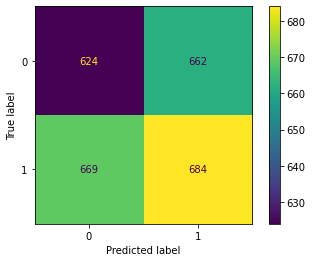

In [73]:
fn.evaluate(knn, X_train, X_test, y_train, y_test)